In [1]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import numpy as np

In [2]:

def create_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier( eval_metric='mlogloss')
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    display(cm)
    return model


def create_reg_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    residuals = y_test - y_pred

    return model


In [3]:
pbp = pd.read_parquet('data/pbp.parquet')
pbp['year'] = pbp['game_id'].apply(lambda x: int(x.split('_')[0]))
small = pbp.loc[pbp.year>2021].dropna(how='all',axis=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards',
       'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'year'],
      dtype='object', length=393)


In [4]:
desc_cols = ['play_id','game_id','home_team','away_team','game_half','posteam','side_of_field','desc']
small.loc[~small.down.isna()][desc_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc
572975,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...
572976,89.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:29) (No Huddle, Shotgun) 19-J.Flacco pass ..."
572977,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...
572978,136.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:01) (No Huddle, Shotgun) 19-J.Flacco pass ..."
572979,172.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(13:53) 7-B.Mann punts 45 yards to BAL 19, Cen..."
...,...,...,...,...,...,...,...,...
698586,4158.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(1:18) (No Huddle, Shotgun) 5-J.Daniels pass s..."
698587,4183.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(:56) (No Huddle, Shotgun) 5-J.Daniels pass sh..."
698588,4217.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(:34) (No Huddle, Shotgun) 5-J.Daniels pass in..."
698589,4240.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(:31) (No Huddle, Shotgun) 5-J.Daniels pass sh..."


In [5]:
play_type_mapping = {
    'field_goal': 0,
    'no_play': 1,
    'pass': 2,
    'punt': 3,
    'qb_kneel': 4,
    'qb_spike': 5,
    'run': 6,
    np.nan: 7
}

In [6]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]

small["play_type_enc"] = small['play_type'].map(play_type_mapping)
y_col = "play_type_enc"
data = small.loc[(~small.down.isna()) & (~small.rush_attempt.isna()) & ~(small.play_type.isna())][game_context_cols + [y_col]]



In [7]:
team_rb_cols = [
    "ppr_roll_RB_0",
    "ppr_roll_RB_1",
    "ppr_roll_RB_2",
    "rush_roll_RB_0",
    "rush_roll_RB_1",
    "rush_roll_RB_2",
    "carries_roll_RB_1",
    "carries_roll_RB_2",
    "carries_roll_RB_0",
]
rusher_stats = ['ppr_roll','rush_roll']

In [ ]:
def get_rusher_number(row):
    for i in range(3):
        if row[f'gsis_id_RB_{i}'] == row['rusher_id']:
            return i
    return None 

def to_quantiles(data:pd.Series, bins:int=6):
    quantiles = pd.qcut(data, q=bins, labels=False)
    print(f'{bins} quantile cutoffs for {data.name}')
    display(data.quantile(np.arange(0,1,1/bins)).reset_index())
    
    return quantiles


In [41]:
rb_stats = pd.read_csv('data/rb_stats.csv',index_col=0)
comb = small.merge(rb_stats,left_on=['posteam','season','week'],
                    right_on=['team_name','season','week']
)
comb['rusher_depth_num'] = comb.apply(get_rusher_number, axis=1)
rushes = comb.loc[(~comb.rusher_depth_num.isna()) & (~comb.yards_gained.isna())].copy(deep=True)
player_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')
rushes = player_stats[['player_id','ppr_roll','rush_roll', 'week','season']].merge(rushes,left_on=['player_id', 'week','season'],right_on=['rusher_id','week','season'])
rushes['yards_quantile'] = to_quantiles(rushes['yards_gained'],5)
rushes['calc_end'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes[(game_context_cols + team_rb_cols)]

5 quantile cutoffs for yards_gained


,index,yards_gained
0,0.0,-13.0
1,0.2,1.0
2,0.4,2.0
3,0.6,4.0
4,0.8,7.0


,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,total_line,ppr_roll_RB_0,ppr_roll_RB_1,ppr_roll_RB_2,rush_roll_RB_0,rush_roll_RB_1,rush_roll_RB_2,carries_roll_RB_1,carries_roll_RB_2,carries_roll_RB_0
0,43.0,2.0,0,10.0,7.0,4.0,329.0,1229.0,3029.0,NaN,...,43.5,14.050000,7.750000,1.233333,67.833333,35.333333,7.0,9.500000,2.000000,17.166667
1,36.0,3.0,0,3.0,7.0,4.0,292.0,1192.0,2992.0,NaN,...,43.5,14.050000,7.750000,1.233333,67.833333,35.333333,7.0,9.500000,2.000000,17.166667
2,39.0,2.0,0,6.0,7.0,-9.0,683.0,1583.0,1583.0,NaN,...,43.5,14.050000,7.750000,1.233333,67.833333,35.333333,7.0,9.500000,2.000000,17.166667
3,93.0,2.0,0,8.0,10.0,-13.0,155.0,1055.0,1055.0,NaN,...,43.5,14.050000,7.750000,1.233333,67.833333,35.333333,7.0,9.500000,2.000000,17.166667
4,2.0,NaN,0,0.0,24.0,-2.0,218.0,218.0,218.0,NaN,...,43.5,14.050000,7.750000,1.233333,67.833333,35.333333,7.0,9.500000,2.000000,17.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30167,85.0,1.0,0,10.0,31.0,25.0,53.0,953.0,953.0,NaN,...,45.5,14.983333,5.433333,1.750000,67.333333,32.166667,5.0,5.833333,1.333333,15.833333
30168,75.0,1.0,0,10.0,31.0,25.0,900.0,900.0,900.0,NaN,...,45.5,14.983333,5.433333,1.750000,67.333333,32.166667,5.0,5.833333,1.333333,15.833333
30169,73.0,2.0,0,8.0,31.0,25.0,861.0,861.0,861.0,NaN,...,45.5,14.983333,5.433333,1.750000,67.333333,32.166667,5.0,5.833333,1.333333,15.833333
30170,59.0,1.0,0,10.0,31.0,25.0,817.0,817.0,817.0,NaN,...,45.5,14.983333,5.433333,1.750000,67.333333,32.166667,5.0,5.833333,1.333333,15.833333


In [10]:
quantiles = [-13, 1, 3, 6]

In [11]:
from statsmodels.nonparametric.kde import KDEUnivariate
import numpy as np
import matplotlib.pyplot as plt

def get_kde(data):
    kde = KDEUnivariate(data)
    kde.fit(gridsize=100, cut=0) 
    

<Axes: >

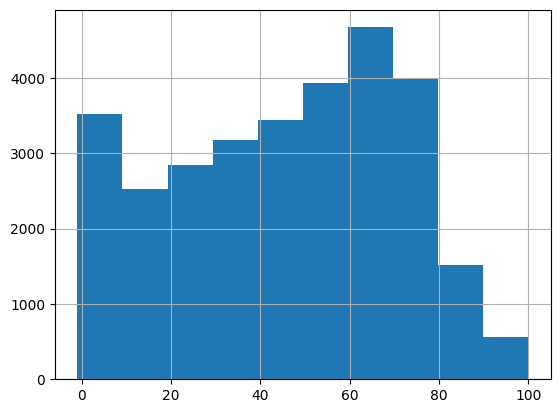

In [46]:
rushes['calc_end'].hist()

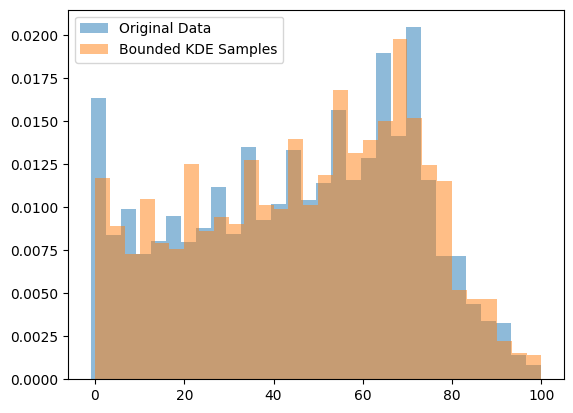

In [55]:

data = rushes['calc_end']
# Fit bounded KDE
kde = KDEUnivariate(data)
kde.fit(gridsize=100, cut=0)  # 'cut=0' ensures the KDE doesn't extend beyond the data range

# Generate samples
yards_to_go = 100
grid = np.linspace(0, 100, 100)
density = kde.evaluate(grid)
samples = np.random.choice(grid, size=10000, p=density / density.sum())

# Visualization
plt.hist(data, bins=30, alpha=0.5, label='Original Data', density=True)
plt.hist(samples, bins=30, alpha=0.5, label='Bounded KDE Samples', density=True)
plt.legend()
plt.show()


(array([  1.,   0.,   2.,   1.,  12.,  15.,  12.,  46., 210.]),
 array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.]),
 <BarContainer object of 9 artists>)

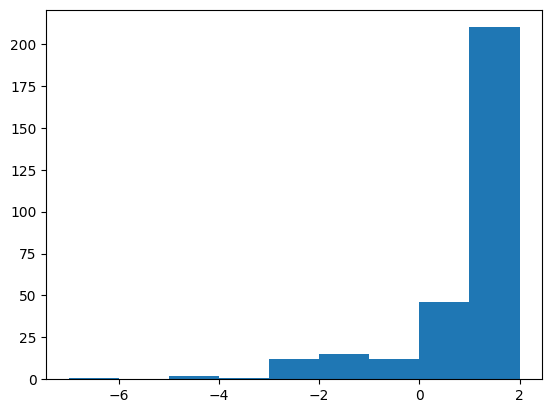

In [112]:
yardline = 2
vals = rushes.loc[rushes.yardline_100 == yardline]['yards_gained'].values
plt.hist(vals, bins=int((vals.max() - vals.min())))

In [113]:
print(len(vals))
(vals==yardline).sum() / len(vals)

299


0.43812709030100333

In [57]:
choose_rusher_cols = (game_context_cols + team_rb_cols)
choose_rusher_model = create_model(comb, x_cols=choose_rusher_cols, y_col='rusher_depth_num')
joblib.dump(choose_rusher_model, 'models/choose_rusher.joblib')

Accuracy: 0.75
Confusion Matrix:


array([[3291,  302,   68],
       [ 732,  978,   54],
       [ 264,  116,  233]], dtype=int64)

['models/choose_rusher.joblib']

In [58]:
rush_yards_cols = (game_context_cols + rusher_stats)
rush_yards_model = create_model(rushes, x_cols=rush_yards_cols, y_col='yards_quantile')
joblib.dump(choose_rusher_model, 'models/rush_yards.joblib')

Accuracy: 0.30
Confusion Matrix:


array([[1182,   66,  371,  172,  103],
       [ 448,   33,  182,   77,   53],
       [ 752,   41,  330,  137,   88],
       [ 504,   16,  252,  140,   79],
       [ 539,   23,  232,  117,   98]], dtype=int64)

['models/rush_yards.joblib']

In [59]:
rushes['pred_quantile'] = rush_yards_model.predict(rushes[rush_yards_cols])

In [60]:
rush_reg_cols = (rush_yards_cols + ['yards_quantile'])
rush_yards_reg = create_reg_model(rushes, x_cols=rush_reg_cols, y_col='yards_gained')
#plain reg model with quantile yards gets MSE of 16.39

Mean Squared Error: 16.35986328125
R-squared: 0.5557059049606323


In [61]:
calc_end_model = create_reg_model(rushes, x_cols=rush_reg_cols, y_col='calc_end')

Mean Squared Error: 16.05010414123535
R-squared: 0.9744808077812195


In [119]:
rushes['pred_yards'] = rush_yards_reg.predict(rushes[rush_reg_cols]).round()
rushes['calc_end_pred'] = calc_end_model.predict(rushes[rush_reg_cols])
rushes['calc_end_yards_gained'] =  rushes['yardline_100'] -rushes['calc_end_pred']
rushes['residuals'] = rushes['pred_yards'] - rushes['yards_gained']
rushes['calc_residuals'] = rushes['calc_end_yards_gained'] - rushes['yards_gained']
rushes['residuals'].apply(lambda x: abs(x)).mean()

1.0882274956913696

In [120]:
rushes[['calc_end_pred','calc_end','calc_end_yards_gained', 'yardline_100','yards_gained','pred_yards','residuals', 'calc_residuals']]

,calc_end_pred,calc_end,calc_end_yards_gained,yardline_100,yards_gained,pred_yards,residuals,calc_residuals
0,36.788776,36.0,6.211224,43.0,7.0,6.0,-1.0,-0.788776
1,30.391773,30.0,5.608227,36.0,6.0,6.0,0.0,-0.391773
2,33.578663,32.0,5.421337,39.0,7.0,6.0,-1.0,-1.578663
3,90.756660,91.0,2.243340,93.0,2.0,2.0,0.0,0.243340
4,2.105342,2.0,-0.105342,2.0,0.0,-1.0,-1.0,-0.105342
...,...,...,...,...,...,...,...,...
30167,76.264084,75.0,8.735916,85.0,10.0,9.0,-1.0,-1.264084
30168,72.696205,73.0,2.303795,75.0,2.0,2.0,0.0,0.303795
30169,65.019028,59.0,7.980972,73.0,14.0,11.0,-3.0,-6.019028
30170,59.182175,60.0,-0.182175,59.0,-1.0,-0.0,1.0,0.817825


In [121]:
rushes['calc_residuals'].apply(lambda x: abs(x)).mean()

1.191610928802169

In [128]:
rushes.loc[rushes.yardline_100 == 4]['yards_gained'].value_counts()

yards_gained
 4.0     59
 3.0     43
 2.0     37
 1.0     37
 0.0     34
-1.0     18
-2.0      9
-4.0      3
-3.0      2
-10.0     1
Name: count, dtype: int64

In [129]:
rushes.loc[rushes.yardline_100 == 4]['pred_yards'].value_counts()

pred_yards
 0.0    87
 4.0    59
 3.0    43
 2.0    35
-1.0    13
-2.0     3
 1.0     3
Name: count, dtype: int64

In [123]:
residuals = rushes.groupby(['yards_quantile'])['residuals'].agg(['std', 'skew']).reset_index()
#residuals = rushes['residuals'].agg(['std', 'skew']).reset_index()
residuals


,yards_quantile,std,skew
0,0,1.354057,1.592798
1,1,0.211973,11.290257
2,2,0.646057,0.745221
3,3,0.821010,0.356629
4,4,6.086236,-2.276066


In [24]:
[x for x in rushes.columns if 'ard' in x]

['yardline_100',
 'yards_gained',
 'air_yards',
 'yards_after_catch',
 'passing_yards',
 'receiving_yards',
 'rushing_yards',
 'lateral_receiving_yards',
 'lateral_rushing_yards',
 'fumble_recovery_1_yards',
 'fumble_recovery_2_yards',
 'return_yards',
 'penalty_yards',
 'drive_yards_penalized',
 'drive_start_yard_line',
 'drive_end_yard_line',
 'xyac_mean_yardage',
 'xyac_median_yardage',
 'ngs_air_yards',
 'yards_quantile',
 'pred_yards',
 'calc_end_yards_gained']

In [25]:
pbp

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type,year
0,1.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,None,None,None,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2010
1,36.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2010
2,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2010
3,82.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2010
4,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698591,4266.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2024
698592,4317.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,None,None,None,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2024
698593,4286.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,PHI,home,WAS,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2024
698594,4334.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,PHI,home,WAS,...,None,NaN,NaN,NaN,NaN,None,None,None,None,2024


<Axes: >

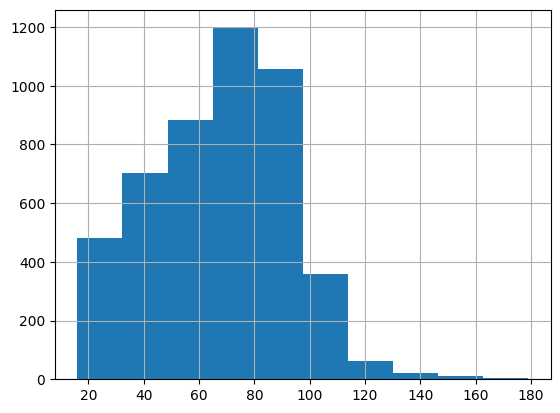

In [26]:
rushes.loc[rushes.yards_quantile==4]['calc_end'].hist()

In [27]:

test = rushes.copy(deep=True)
test = test.merge(residuals)
test['new_pred'] = test['std'].apply(lambda x: np.random.normal(0, x)) + test['yards_gained']
test['new_pred'] = test['new_pred'].round()
test

#test =test.loc[test.yards_quantile== 0]

,player_id,ppr_roll,rush_roll,week,season,play_id,game_id,old_game_id,home_team,away_team,...,calc_end,pred_quantile,pred_yards,calc_end_pred,calc_end_yards_gained,residuals,calc_residuals,std,skew,new_pred
0,00-0027966,7.750000,35.333333,1,2022,741.0,2022_01_NO_ATL,None,ATL,NO,...,50.0,0,5.805745,48.639446,-5.639446,-1.194255,-12.639446,0.779109,0.467820,6.0
1,00-0027966,7.750000,35.333333,1,2022,762.0,2022_01_NO_ATL,None,ATL,NO,...,42.0,0,5.758417,42.193729,-6.193729,-0.241583,-12.193729,0.779109,0.467820,6.0
2,00-0027966,7.750000,35.333333,1,2022,2183.0,2022_01_NO_ATL,None,ATL,NO,...,46.0,3,5.643087,44.656475,-5.656475,-1.356913,-12.656475,0.779109,0.467820,7.0
3,00-0027966,7.750000,35.333333,1,2022,2741.0,2022_01_NO_ATL,None,ATL,NO,...,95.0,1,1.667287,94.986603,-1.986603,-0.332713,-3.986603,0.243327,7.164741,2.0
4,00-0027966,7.750000,35.333333,1,2022,3696.0,2022_01_NO_ATL,None,ATL,NO,...,2.0,0,-0.594431,1.618729,0.381271,-0.594431,0.381271,1.342047,1.660576,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30167,00-0039921,5.433333,32.166667,10,2024,2935.0,2024_10_NYJ_ARI,2024111009,ARI,NYJ,...,95.0,0,8.613637,95.565300,-10.565300,-1.386363,-20.565300,6.073845,-2.285201,21.0
30168,00-0039921,5.433333,32.166667,10,2024,2986.0,2024_10_NYJ_ARI,2024111009,ARI,NYJ,...,77.0,0,2.073424,76.811348,-1.811348,0.073424,-3.811348,0.243327,7.164741,2.0
30169,00-0039921,5.433333,32.166667,10,2024,3008.0,2024_10_NYJ_ARI,2024111009,ARI,NYJ,...,87.0,0,10.710053,83.882683,-10.882683,-3.289947,-24.882683,6.073845,-2.285201,20.0
30170,00-0039921,5.433333,32.166667,10,2024,3030.0,2024_10_NYJ_ARI,2024111009,ARI,NYJ,...,58.0,0,-0.339298,58.569523,0.430477,0.660702,1.430477,1.342047,1.660576,-1.0


In [28]:
from sklearn.neighbors import KernelDensity

test = rushes.copy(deep=True)

test['pred_quantile'] = rush_yards_model.predict(rushes[rush_yards_cols])

kde_models = {}
for quartile in range(0, 5):
    kde = KernelDensity(kernel='gaussian', bandwidth=1.0)
    kde.fit(data.loc[data['yards_quantile'] == quartile, 'yards_gained'].values.reshape(-1, 1))
    kde_models[quartile] = kde
test['kde'] = test['yards_quantile'].apply(lambda x: kde_models[x].sample(1)[0][0]).round()
test[['kde', 'yards_gained']].hist(sharey=True)

KeyError: 'yards_quantile'

<Axes: >

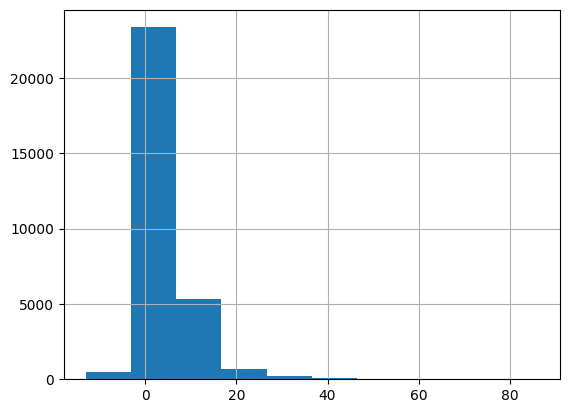

In [ ]:
test['kde'].hist()

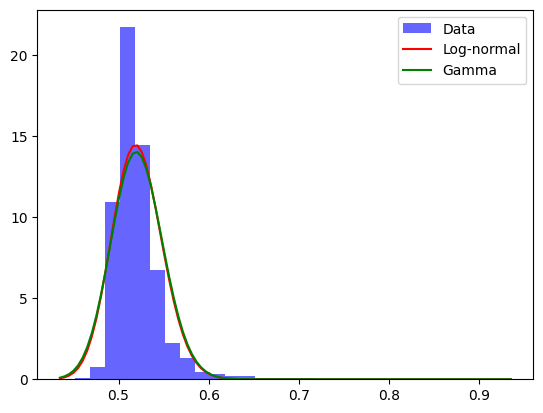

In [ ]:
import numpy as np
from scipy.stats import lognorm, gamma, expon
import matplotlib.pyplot as plt

# Replace with your data
data = test['yards_gained'].values # Replace with your actual data
data = (data + 100) / 200
# Fit distributions
params_lognorm = lognorm.fit(data, floc=0)  # Log-normal
params_gamma = gamma.fit(data, floc=0)     # Gamma          # Exponential

# Plot histogram and fitted distributions
x = np.linspace(min(data), max(data), 100)
plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', label='Data')

plt.plot(x, lognorm.pdf(x, *params_lognorm), label='Log-normal', color='red')
plt.plot(x, gamma.pdf(x, *params_gamma), label='Gamma', color='green')

plt.legend()
plt.show()

<Axes: >

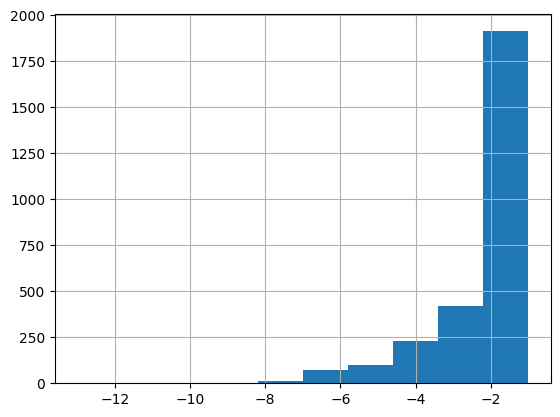

In [ ]:
test['yards_gained'].hist()

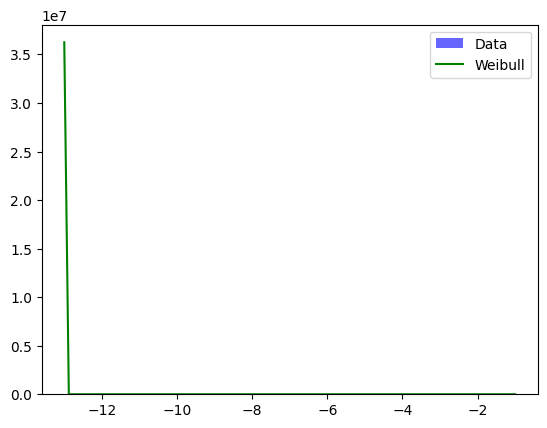

In [ ]:
from scipy.stats import weibull_min

# Fit the Weibull distribution
c, loc, scale = weibull_min.fit(data)

# Plot the Weibull fit
x = np.linspace(min(data), max(data), 100)
plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', label='Data')
plt.plot(x, weibull_min.pdf(x, c, loc, scale), label='Weibull', color='green')
plt.legend()
plt.show()

<Axes: xlabel='yardline_100', ylabel='yards_gained'>

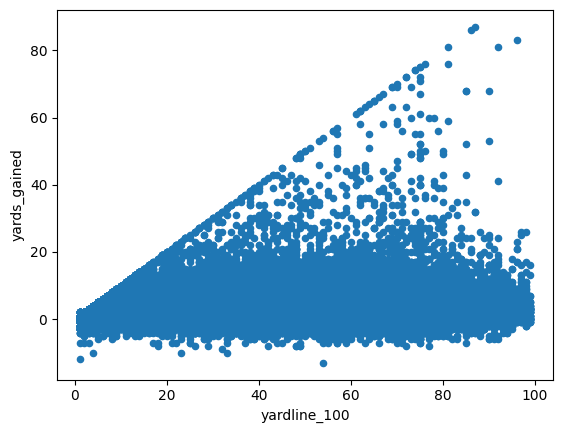

In [ ]:
rushes[['yardline_100','yards_gained']].plot.scatter('yardline_100', 'yards_gained')

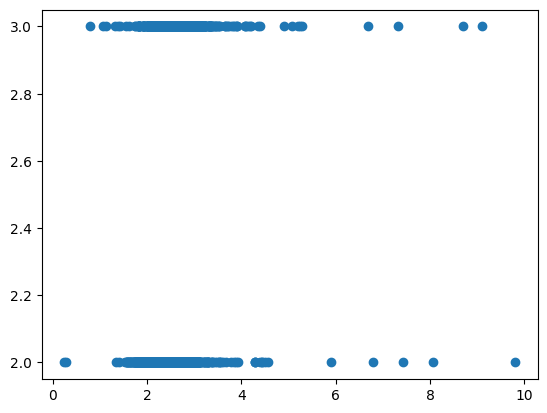

In [ ]:
small = rushes.loc[rushes.yards_quantile==1]
plt.scatter(small['pred_yards'], small['yards_gained'])

In [ ]:
small['pred_yards'].std()

np.float32(0.3318868)

In [ ]:
small['yards_gained'].std()

np.float32(0.49987814)

In [ ]:
feature_config = {
    'choose_rusher_cols':choose_rusher_cols,
    'rush_yards_cols':rush_yards_cols
}
feature_config

{'choose_rusher_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'ppr_roll_RB_0',
  'ppr_roll_RB_1',
  'ppr_roll_RB_2',
  'rush_roll_RB_0',
  'rush_roll_RB_1',
  'rush_roll_RB_2',
  'carries_roll_RB_1',
  'carries_roll_RB_2',
  'carries_roll_RB_0'],
 'rush_yards_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'ppr_roll',
  'rush_roll']}

In [ ]:
yaml_path = "models/feature_config.yaml"
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)  # Load the current content of the YAML file

# Update the data with the provided updates
data.update(feature_config)

with open(yaml_path, 'w') as file:
    yaml.safe_dump(data, file)

In [ ]:
def rush_yards_pred(X):
    quantile = rush_yards_model(X)
    